Install required libraries 

In [ ]:
# !pip install -q torch transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl pacmap datasets langchain-community ragatouille

^C


In [ ]:
# !pip install datasets

  Using cached datasets-4.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached xxhash-3.5.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
Using cached datasets-4.0.0-py3-none-any.whl (494 kB)
Using cached fsspec-2025.3.0-py3-none-any.whl (193 kB)
Using cached huggingface_hub-0.34.4-py3-none-any.whl (561 kB)

   -------- ------------------------------- 1/5 [multiprocess]
   -------- ------------------------------- 1/5 [multiprocess]
  Attempting uninstall: fsspec
   -------- ------------------------------- 1/5 [multiprocess]
    Found existing installation: fsspec 2025.3.2
   -------- ------------------------------- 1/5 [multiprocess]
    Uninstalling fsspec-2025.3.2:
   -------- ------------------------------- 1/5 [multiprocess]
      Successfully uninstalled fsspec-2025.3.2
   ----

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2025.3.2 requires fsspec==2025.3.2.*, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)

In [4]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [5]:
# !pip install langchain

In [6]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"],metadata={"source": doc["source"]}) for doc in tqdm(ds)
]


  0%|          | 0/2647 [00:00<?, ?it/s]

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
   chunk_size=1000,
   chunk_overlap=100,
   add_start_index=True, # If `True`, includes chunk's start index in metadata
   strip_whitespace=True, # If `True`, strips whitespace from the start and end of every document
   separators=MARKDOWN_SEPARATORS
)


In [8]:
docs_processed = []

for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

In [9]:
docs_processed

[Document(metadata={'source': 'huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx', 'start_index': 1}, page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<i

We also have to keep in mind that when embedding documents, we will use an embedding model that accepts a certain maximum sequence length max_seq_length.

So we should make sure that our chunk sizes are below this limit because any longer chunk will be truncated before processing, thus losing relevancy.

In [10]:
from sentence_transformers import SentenceTransformer

print(f"Model's max seq length: {SentenceTransformer('thenlper/gte-small').max_seq_length}")

Model's max seq length: 512


In [11]:
from transformers import AutoTokenizer

tokenizer  = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

  0%|          | 0/31085 [00:00<?, ?it/s]

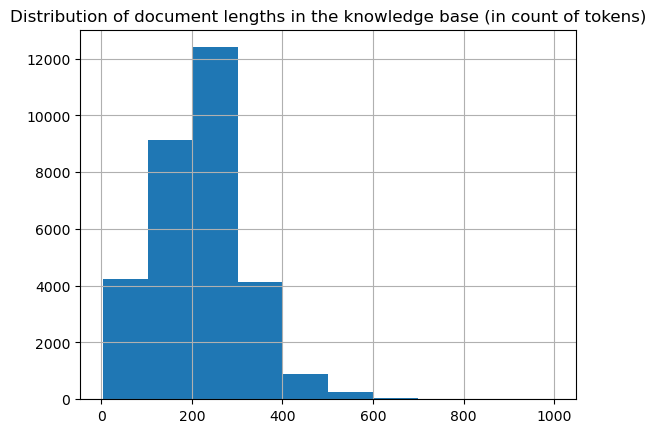

In [12]:
# Plot the distribution of document lengths, counted as the number of tokens

figure = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [13]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"

def split_documents(
  chunk_size: int,
  kb_article:List[LangchainDocument],
  tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME    
) -> List[LangchainDocument] :
    """
    Split document into chunks of maximum size 'chunk size' token and return a list of unique documents
    """

    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size = chunk_size,
        chunk_overlap = int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators = MARKDOWN_SEPARATORS
    )

    docs_processed = []
    for doc in kb_article:
        docs_processed += text_splitter.split_documents([doc])

    # remove duplicates

    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content]=True
            docs_processed_unique.append(doc)

    return docs_processed_unique


In [14]:
docs_processed = split_documents(
    512,     # We choose a chunk size=512 as per our model embedding model's max sent size 
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME
)

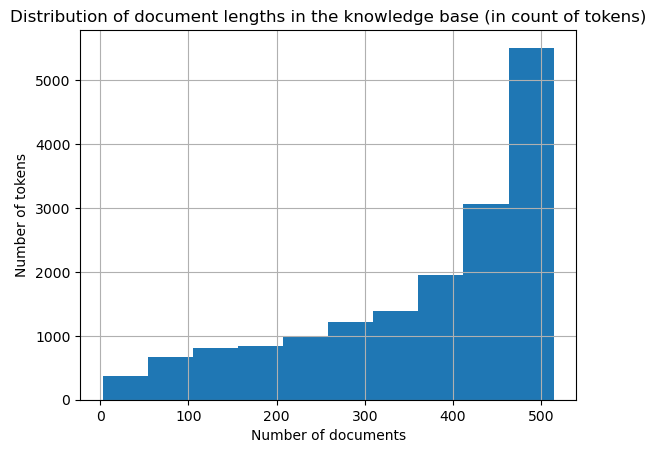

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content))  for doc in docs_processed]

figure = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.ylabel("Number of tokens")
plt.xlabel("Number of documents")
plt.show()


In [16]:
docs_processed

[Document(metadata={'source': 'huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx', 'start_index': 1}, page_content='Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<i

In [17]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


Building vector DB 

In [ ]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    # model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

KNOWLEDGE_VECTOR_DB = FAISS.from_documents(
    docs_processed,
    embedding_model, 
    distance_strategy=DistanceStrategy.COSINE
)